In [29]:
import rasterio
from rasterio import plot
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import os
import math
import seaborn as sns
from typing import List, Dict

sns.set_theme()

In [2]:
dataset_dir = os.path.join('data', 'dataset')
training_dir = os.path.join(dataset_dir, 'training')
validation_dir = os.path.join(dataset_dir, 'validation')
test_dir = os.path.join(dataset_dir, 'test')
out_labels_path = os.path.join('out', 'labels_checked.csv')

In [3]:
station_radius = 8000.0

In [4]:
def load_image(path:str) -> rasterio.DatasetReader:
    return rasterio.open(path)

In [5]:
stations = os.listdir(training_dir)

In [6]:
if os.path.exists(out_labels_path):
    labels = pd.read_csv(out_labels_path, index_col=0)
else:
    labels = pd.concat([
        pd.read_csv(os.path.join(dataset_dir, 'training_labels.csv')),
        pd.read_csv(os.path.join(dataset_dir, 'validation_labels.csv')),
        pd.read_csv(os.path.join(dataset_dir, 'test_labels.csv'))
    ], ignore_index=True)
    labels['true cloud cover'] = None


In [7]:
labels

,max cloud cover,temperature [C],timedelta [minutes],station,product_id,true cloud cover
0,CLR,5.9,-11.983733,COF,0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9,CLR
1,CLR,6.1,-13.983733,MLB,0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9,CLR
2,CLR,6.0,-19.983733,TIX,0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9,CLR
3,CLR,4.6,-11.983733,TTS,0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9,CLR
4,CLR,5.5,-11.983733,XMR,0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9,FEW
...,...,...,...,...,...,...
10991,BKN,18.3,15.482933,SNA,ff4c1688-498e-4d57-b6fc-8793705ae87b,NaN
10992,OVC,12.2,19.516267,NUC,ff7b2786-370d-4270-a015-2b17deba4fbf,NaN
10993,CLR,12.0,4.816267,F45,ffb370c5-e380-424c-9ddc-ba0f76149481,NaN
10994,SCT,7.2,-5.150400,STS,ffcb7dba-8287-4d61-b3f8-268beba9901d,NaN


In [8]:
cloud_cover_order = ['CLR', 'FEW', 'SCT', 'BKN', 'OVC']

In [9]:
print(labels[~labels['true cloud cover'].isna()].index.to_list())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [10]:
image_index = labels[labels['true cloud cover'].isin(cloud_cover_order)].last_valid_index()
if image_index is None:
    image_index = 0
else:
    image_index += 1

In [34]:
import PySimpleGUI as sg
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import torch
from torchvision import transforms

def get_window_title() -> str:
    return f'{image_index + 1} / {labels.shape[0]} [{float(image_index + 1) / float(labels.shape[0]) * 100.0:.1f} %]'

def plot_image(index):
    def get_image_path(row, dir:str):
        return os.path.join(dir, row['station'], row['product_id'] + '.tif')
    row = labels.iloc[index]
    img_path = get_image_path(row, training_dir)
    if not os.path.exists(img_path):
        img_path = get_image_path(row, validation_dir)
    if not os.path.exists(img_path):
        img_path = get_image_path(row, test_dir)
    if not os.path.exists(img_path):
        raise RuntimeError('Unable to find ' + os.path.join(row['station'], row['product_id'] + '.tif'))
    image: rasterio.DatasetReader = load_image(img_path)
    image_tensor = torch.from_numpy(image.read())
    image.close()
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.axis('off')
    delta_minutes: float = row['timedelta [minutes]']
    ax.set_title(row['max cloud cover'] + f' | {delta_minutes:.1f} [minutes]', fontsize=28)
    ax.imshow(image_tensor.permute(1, 2, 0))
    return fig, ax

def draw_image(canvas, figure):
    agg = FigureCanvasTkAgg(figure, canvas)
    agg.draw()
    agg.get_tk_widget().pack(side='top', fill='both', expand=True)
    return agg

fig, ax = plot_image(image_index)
figure_x, figure_y, figure_w, figure_h = fig.bbox.bounds

layout = [[sg.Canvas(size=(figure_w, figure_h), key='canvas')], [sg.Button(cc) for cc in cloud_cover_order] + [sg.Button('<--')]]

font = ('Inter', 16)
window = sg.Window(get_window_title(), layout, element_justification='c', font=font, finalize=True)

agg = draw_image(window['canvas'].TKCanvas, fig)
while True:
    event, values = window.read()
    # End program if user closes window
    if event == sg.WIN_CLOSED:
        agg.get_tk_widget().forget()
        plt.close('all')
        labels.to_csv(out_labels_path)
        break
    if event in cloud_cover_order or event == '<--':
        labels.at[image_index, 'true cloud cover'] = event
        if event == '<--':
            image_index -= 1
        else:
            image_index += 1
        if image_index < labels.shape[0]:
            agg.get_tk_widget().forget()
            plt.close('all')
            fig, ax = plot_image(image_index)
            window.set_title(get_window_title())
            agg = draw_image(window['canvas'].TKCanvas, fig)
            window.refresh()
        else:
            break
        labels.to_csv(out_labels_path)

window.close()

In [13]:
labels_to_analyze = labels[~labels['true cloud cover'].isna()].copy()
labels_to_analyze

,max cloud cover,temperature [C],timedelta [minutes],station,product_id,true cloud cover
0,CLR,5.9,-11.983733,COF,0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9,CLR
1,CLR,6.1,-13.983733,MLB,0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9,CLR
2,CLR,6.0,-19.983733,TIX,0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9,CLR
3,CLR,4.6,-11.983733,TTS,0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9,CLR
4,CLR,5.5,-11.983733,XMR,0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9,FEW
...,...,...,...,...,...,...
2995,OVC,9.0,-1.517067,OAR,4ee58321-682b-4da8-aa22-f6cc8c35e143,BKN
2996,OVC,10.0,-3.517067,SNS,4ee58321-682b-4da8-aa22-f6cc8c35e143,BKN
2997,CLR,15.6,16.149600,BUR,4ef86dff-32a0-4b48-8bc2-026bbab5da8d,CLR
2998,CLR,17.8,10.149600,CQT,4ef86dff-32a0-4b48-8bc2-026bbab5da8d,CLR


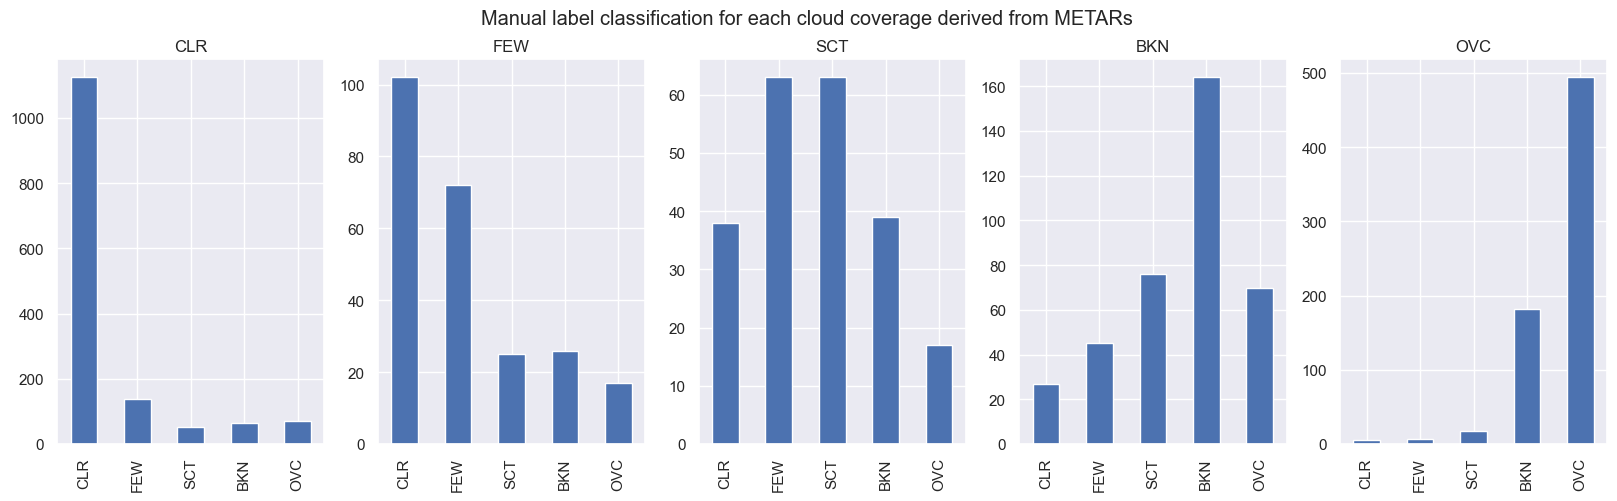

In [14]:
from collections import Counter

cc_counts = {}
fig, axs = plt.subplots(figsize=(4 * len(cloud_cover_order), 5), ncols=len(cloud_cover_order))
fig.suptitle('Manual label classification for each cloud coverage derived from METARs')
for i, cc in enumerate(cloud_cover_order):
    ax: plt.Axes = axs[i]
    counted_labels = pd.Series(Counter(labels_to_analyze[labels_to_analyze['max cloud cover'] == cc]['true cloud cover']))
    for cc_ in cloud_cover_order:
        if cc_ not in counted_labels:
            counted_labels[cc_] = 0
    counted_labels = counted_labels.loc[cloud_cover_order]
    counted_labels.plot.bar(ax=ax, title=cc)
    cc_counts[cc] = counted_labels

In [15]:
# rows   = manually selected label
# colums = label given by METAR
cc_dist = pd.DataFrame(cc_counts)
cc_dist

,CLR,FEW,SCT,BKN,OVC
CLR,1124,102,38,27,5
FEW,139,72,63,45,7
SCT,52,25,63,76,18
BKN,64,26,39,164,182
OVC,71,17,17,70,494


In [16]:
cc_dist_rel = (cc_dist.T / cc_dist.sum(axis=1)).T
assert(all([math.isclose(x, 1.0) for x in cc_dist_rel.sum(axis=1)]))
cc_dist_rel

,CLR,FEW,SCT,BKN,OVC
CLR,0.867284,0.078704,0.029321,0.020833,0.003858
FEW,0.426380,0.220859,0.193252,0.138037,0.021472
SCT,0.222222,0.106838,0.269231,0.324786,0.076923
BKN,0.134737,0.054737,0.082105,0.345263,0.383158
OVC,0.106129,0.025411,0.025411,0.104634,0.738416


In [30]:
def direct_neighbor_accumulation(data_collection:List[pd.DataFrame], labels:List[str]) -> pd.DataFrame:
    result = []
    for i, cc in enumerate(cloud_cover_order):
        local_result = {'cloud cover': cc}
        for k, data in enumerate(data_collection):
            cc_sum = data.loc[cc, cc]
            if i > 0:
                cc_sum += data.loc[cc, cloud_cover_order[i - 1]]
            if i < len(cloud_cover_order) - 1:
                cc_sum += data.loc[cc, cloud_cover_order[i + 1]]
            local_result[labels[k]] = cc_sum
        result += [local_result]
    result = pd.DataFrame(result)
    result.set_index('cloud cover', inplace=True)
    return result

cc_neighbor_acc = direct_neighbor_accumulation([cc_dist_rel], ['f1_score'])
cc_neighbor_acc

,f1_score
cloud cover,
CLR,0.945988
FEW,0.840491
SCT,0.700855
BKN,0.810526
OVC,0.843049


(0.0, 1.0)

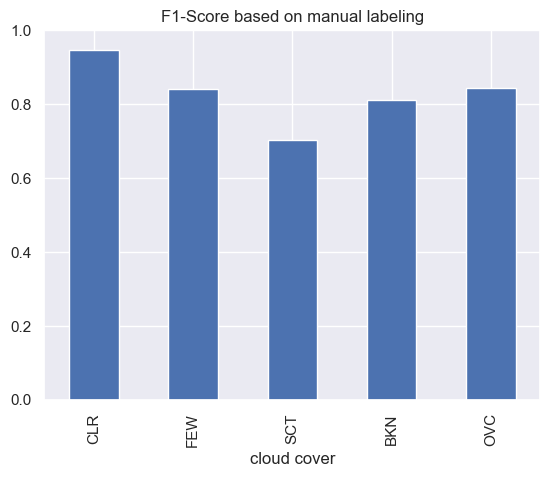

In [36]:
ax = cc_neighbor_acc.plot.bar(legend=False, title='F1-Score based on manual labeling')
ax.set_ylim(0, 1)

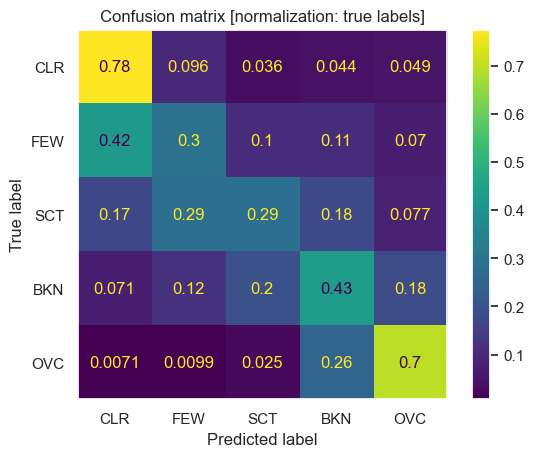

In [18]:
# compute the confusion matrix
from enum import Enum
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


class_names =   ['CLR', 'FEW', 'SCT', 'BKN', 'OVC']
classes = list(range(len(class_names)))
class_dict = {name: i for i, name in enumerate(class_names)}

class ConfusionMatrixNormalization(str, Enum):
    ALL_SAMPLES = 'all',
    TRUE_LABELS = 'true',
    PREDICTED_LABELS = 'pred'

normalization = ConfusionMatrixNormalization.TRUE_LABELS
normalization_mode = None
title = 'Confusion matrix'
if normalization is not None:
    normalization_mode = normalization.value
    title += ' [normalization: ' + normalization.name.lower().replace('_', ' ') + ']'
# set the model to evaluation mode

cm = confusion_matrix(y_true=labels_to_analyze['max cloud cover'].apply(lambda x: class_dict[x]),
                      y_pred=labels_to_analyze['true cloud cover'].apply(lambda x: class_dict[x]),
                      labels=range(len(cloud_cover_order)), normalize=normalization_mode)

# display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cloud_cover_order)
disp.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')
plt.grid(False)
plt.title(title)
plt.show()

In [19]:
mislabeled = labels_to_analyze['max cloud cover'] != labels_to_analyze['true cloud cover']

<Axes: title={'center': 'Frequency of mislabeling based on METAR labels'}, xlabel='max cloud cover'>

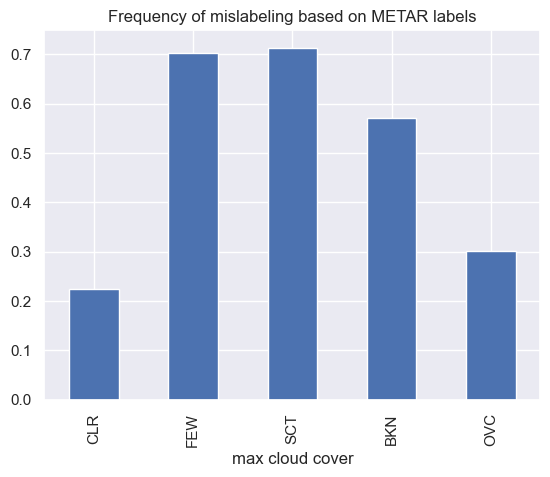

In [20]:
(labels_to_analyze[mislabeled].groupby('max cloud cover')['true cloud cover'].count().loc[cloud_cover_order] / labels_to_analyze.groupby('max cloud cover')['true cloud cover'].count().loc[cloud_cover_order]).plot.bar(title='Frequency of mislabeling based on METAR labels')

Text(0.5, 1.0, 'Time difference between satellite image\nand METAR observation [mislabeled]')

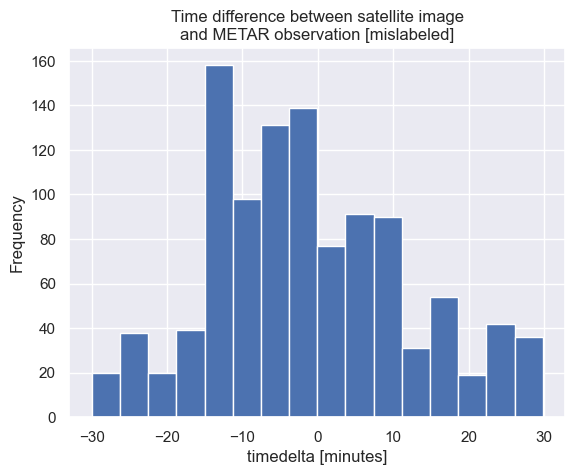

In [43]:
ax = labels_to_analyze[mislabeled]['timedelta [minutes]'].plot.hist(bins=16)
ax.set_xlabel('timedelta [minutes]')
ax.set_title('Time difference between satellite image\nand METAR observation [mislabeled]')

Text(0.5, 1.0, 'Time difference between satellite image\nand METAR observation [correctly labeled]')

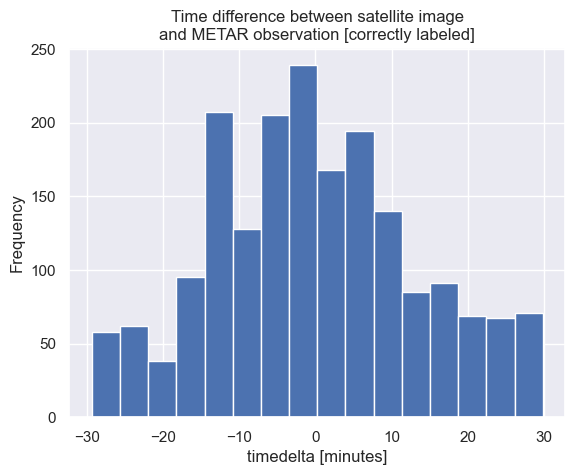

In [44]:
ax = labels_to_analyze[~mislabeled]['timedelta [minutes]'].plot.hist(bins=16)
ax.set_xlabel('timedelta [minutes]')
ax.set_title('Time difference between satellite image\nand METAR observation [correctly labeled]')

Text(0.5, 1.0, 'Time Differences of Mislabeled Data')

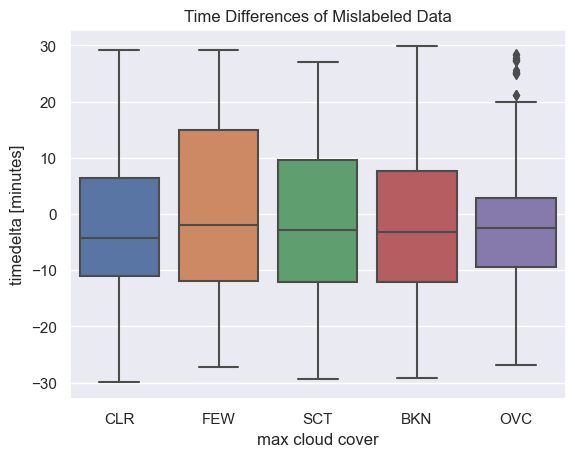

In [56]:
ax = sns.boxplot(labels_to_analyze[mislabeled], x='max cloud cover', y='timedelta [minutes]', order=cloud_cover_order)
ax.set_title('Time Differences of Mislabeled Data')

In [24]:
mislabels_by_station = labels_to_analyze[mislabeled].groupby('station')['max cloud cover'].count()
labels_by_station = labels_to_analyze.groupby('station')['max cloud cover'].count()

In [25]:
mislabels_by_station_rel = []
for i, count in mislabels_by_station.items():
    mislabels_by_station_rel += [{'station': i, 'frequency': count / labels_by_station.loc[i]}]
mislabels_by_station_rel = pd.DataFrame(mislabels_by_station_rel)
mislabels_by_station_rel.set_index('station', inplace=True)
mislabels_by_station_rel.sort_values('frequency', inplace=True)
mislabels_by_station_rel

,frequency
station,
CQT,0.083333
BUR,0.083333
TCY,0.090909
JAQ,0.090909
AUN,0.090909
...,...
LNA,0.777778
MCO,0.777778
28J,0.777778


(0.0, 100.0)

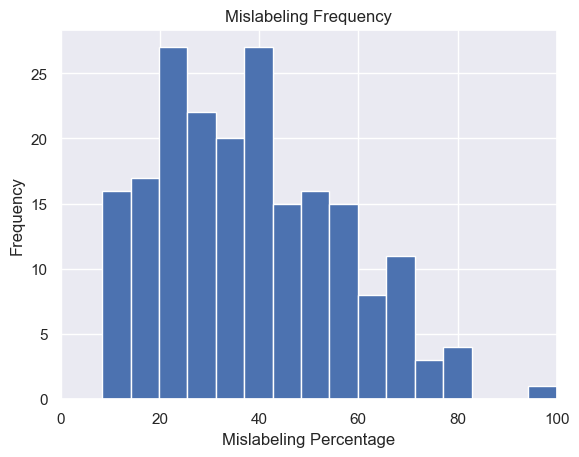

In [54]:
ax = (mislabels_by_station_rel * 100).plot.hist(bins=16, title='Mislabeling Frequency', legend=False)
ax.set_xlabel('Mislabeling Percentage')
ax.set_xlim(0, 100)

<Axes: xlabel='station'>

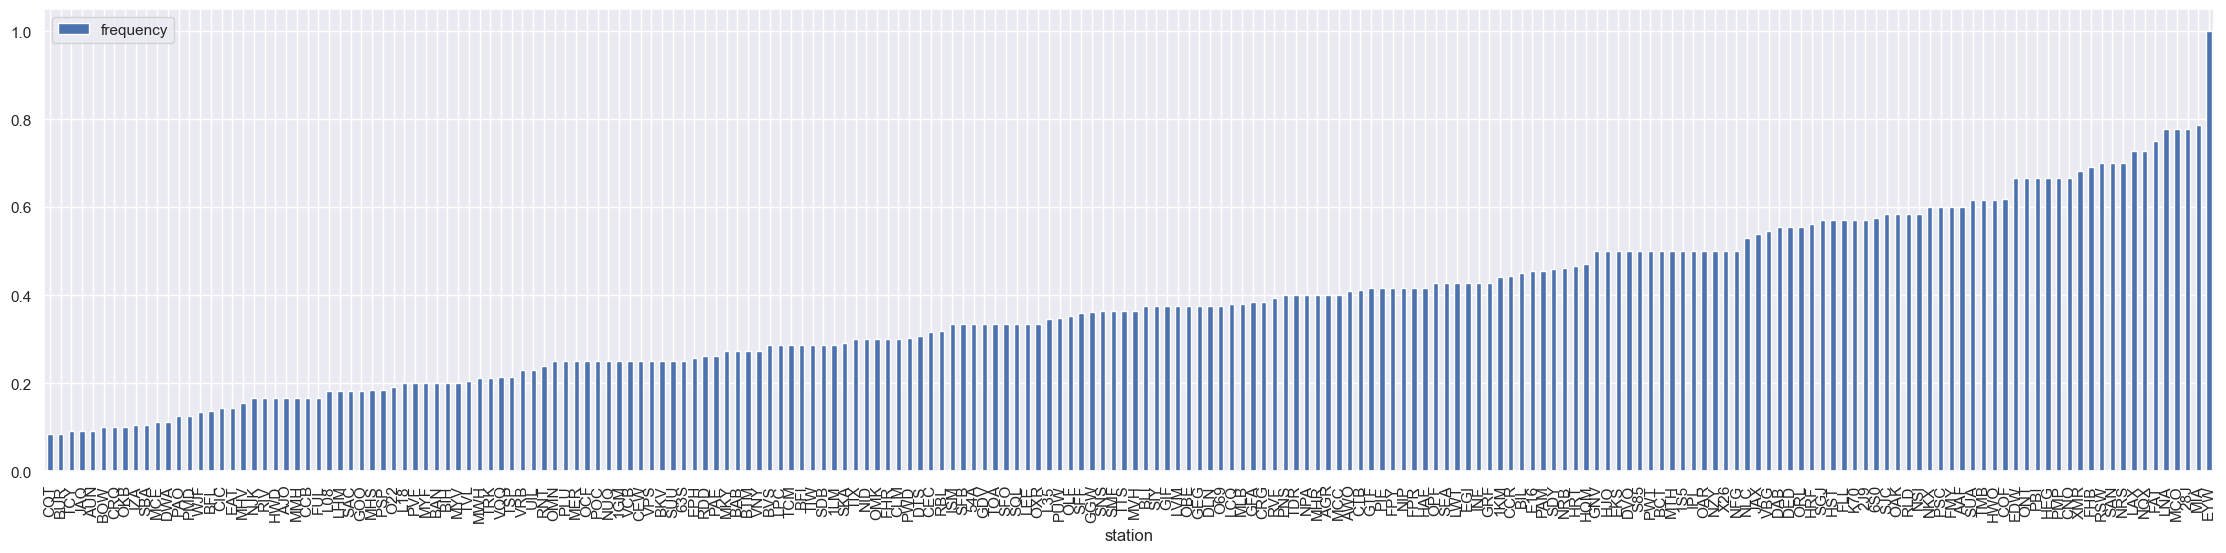

In [27]:
fig, ax = plt.subplots(figsize=(28, 6))
mislabels_by_station_rel.plot.bar(ax=ax)

In [119]:
import shapely

station_metadata = []
for state in ['California', 'Florida', 'Montana', 'Washington']:
    station_metadata += [pd.read_csv(os.path.join('data', 'queries', state, 'preprocessing', 'station_metadata.csv'))]
station_metadata = pd.concat(station_metadata)
station_metadata['geometry'] = station_metadata['geometry'].apply(shapely.from_wkt)
station_metadata: gpd.GeoDataFrame = gpd.GeoDataFrame(station_metadata, crs='EPSG:4326')
station_metadata.set_index('id', inplace=True)
station_metadata.head()

,geometry,name,plot_name,network,latitude,longitude,elevation,index_right,ISO_A3_EH,country,CONTINENT,distance_to_region
id,,,,,,,,,,,,
AZ4299,POINT (-114.46667 32.88333),AZ4299,IMPERIAL DAM,AZCLIMATE,32.88333,-114.46667,52.1208,154,USA,United States of America,North America,0.0
AZ8678,POINT (-114.48333 34.71667),AZ8678,TOPOCK,AZCLIMATE,34.71667,-114.48333,136.8552,154,USA,United States of America,North America,0.0
AZ9662,POINT (-114.61667 32.73333),AZ9662,YUMA WB CITY,AZCLIMATE,32.73333,-114.61667,73.1520,154,USA,United States of America,North America,0.0
AAT,POINT (-120.56444 41.49139),AAT,NaN,CA_ASOS,41.49139,-120.56444,1333.0000,154,USA,United States of America,North America,0.0
ACV,POINT (-124.10861 40.97811),ACV,NaN,CA_ASOS,40.97811,-124.10861,66.0000,154,USA,United States of America,North America,0.0


In [128]:
station_metadata['mislabeled'] = np.nan

In [129]:
for station, mislabeled in mislabels_by_station_rel['frequency'].items():
    station_metadata.loc[station, 'mislabeled'] = mislabeled

In [130]:
station_metadata = gpd.GeoDataFrame(station_metadata[~station_metadata['mislabeled'].isna()])

In [143]:
usa_states: gpd.GeoDataFrame = gpd.read_file('input/us_states_5m.geojson')
usa_states.set_index('NAME', inplace=True)

(22.0, 50.0)

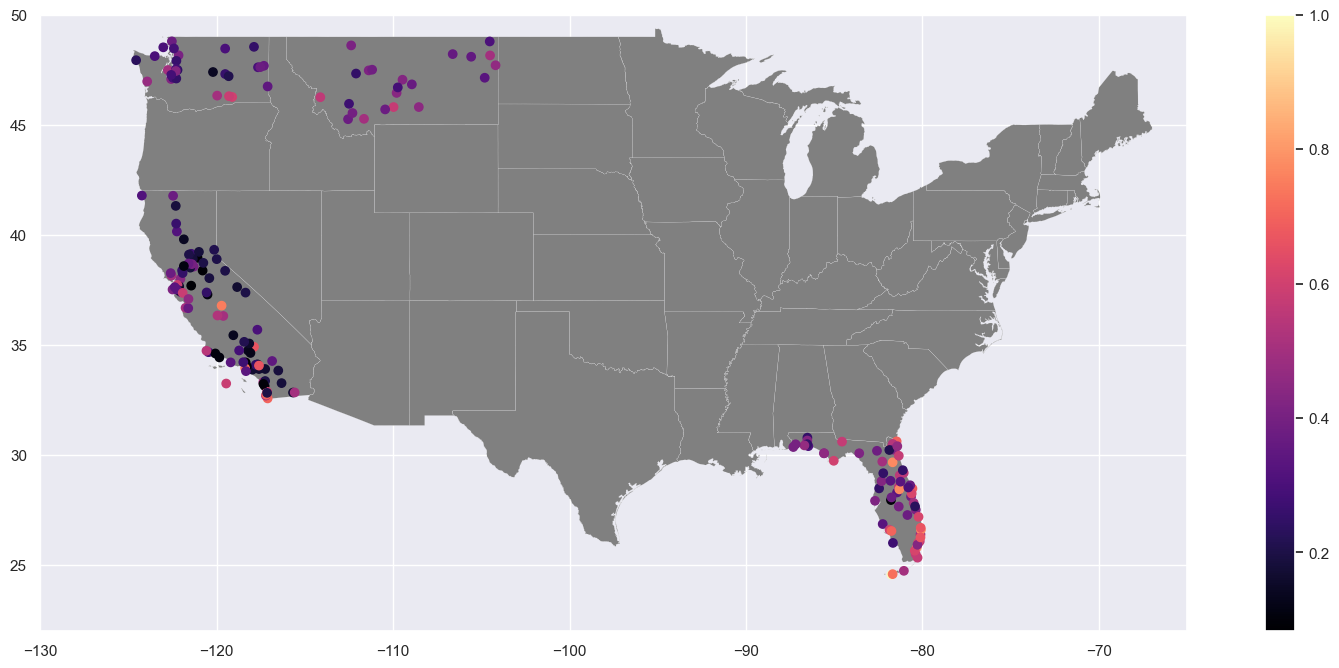

In [194]:
assert isinstance(station_metadata, gpd.GeoDataFrame)
fig, ax = plt.subplots(figsize=(20, 8))
usa_states.plot(ax=ax, facecolor='grey', linewidth=0.1)
station_metadata.plot('mislabeled', cmap='magma', ax=ax, legend=True)
ax.set_xlim(-130, -65)
ax.set_ylim(22, 50)